# RFM Analysis & K-Means Clustering
GitHub location: https://github.com/LarsTinnefeld/olist_ecom_analysis.git

**A project of the Olist ecommerce business analysis.**

<img src="https://i2.wp.com/dataneophyte.com/wp-content/uploads/2019/12/Logo-01.png" width="400" height="300">

## Questions to answer
1. Strategy to target specific customer segments
2. Evaluation of RFM analysis: Can we see segmentation from a different angle?

---
## Table of Contents

I. [Data Import and Wrangling](#data)<br>
II. [Exploratory Analysis](#eda)<br>
III. [RFM Analysis](#rfm)<br>
IV. [K Means Clustering](#k_means)<br>

---
## <a class="anchor" id="data">I. Data Import and Wrangling</a>

### 1. Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from Olist_classes import Olist_analysis as oa

init_notebook_mode(connected=True)
%matplotlib inline

### 2. Importing data

Data structure:

In [2]:
# Import data table from "Customer Segmentation" analysis
df_segmented_customers = pd.read_csv('../0 - Data/segmented_customers.csv')

In [3]:
df_segmented_customers.drop('Unnamed: 0', axis=1, inplace=True)
df_segmented_customers.head()

,customer_unique_id,recency,days_since_first_order,frequency,total_payment,avg_payment,segment,sub_segment,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,color
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,129.90,129.90,active,active_high,7787,-23.353375,-46.824556,red
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,18.90,18.90,active,active_low,6053,-23.559455,-46.789721,deeppink
2,0000f46a3911fa3c0805444483337064,537,537,1,69.00,69.00,inactive,inactive,88115,-27.535895,-48.630935,midnightblue
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,25.99,25.99,hot,hot_low,66812,-1.307324,-48.481083,darkorchid
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,180.00,180.00,hot,hot_high,18040,-23.508786,-47.462823,magenta


In [4]:
df_segmented_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_unique_id           93358 non-null  object 
 1   recency                      93358 non-null  int64  
 2   days_since_first_order       93358 non-null  int64  
 3   frequency                    93358 non-null  int64  
 4   total_payment                93358 non-null  float64
 5   avg_payment                  93358 non-null  float64
 6   segment                      93358 non-null  object 
 7   sub_segment                  93358 non-null  object 
 8   geolocation_zip_code_prefix  93358 non-null  int64  
 9   geolocation_lat              93103 non-null  float64
 10  geolocation_lng              93103 non-null  float64
 11  color                        93358 non-null  object 
dtypes: float64(4), int64(4), object(4)
memory usage: 8.5+ MB


In [5]:
# Create work copy
df_rfm = df_segmented_customers[[
    'customer_unique_id',
    'recency',
    'frequency',
    'total_payment',
    'avg_payment',
    'geolocation_zip_code_prefix',
    'geolocation_lat',
    'geolocation_lng'
    ]].copy()

---
## <a class="anchor" id="eda">II. Exploratory Data Analysis</a>
The focus is on getting an understanding about the customers buying habits and their locations.

In [6]:
def rfm_iso_scatter(dat, x, y, z):

    '''
    Function to generate a 3D scatter plot

    Input:
    - dat - dataframe
    - x, y, z - 3 features for the three coordinates

    Output:
    - None (interactive 3D scatter plot)
    '''
    x = dat[x]
    y = dat[dat[y]<5][y]
    z = dat[dat[z]<4000][z]


    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=1,
            color=y,               
            colorscale='thermal',
            opacity=0.8
        )
    )])

    fig.update_layout(scene = dict(
        xaxis_title='Recency',
        yaxis_title='Frequency',
        zaxis_title='Monetary'),
        width=700,
        margin=dict(r=20, b=10, l=10, t=10))

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

In [7]:
# Generate 3d scatter of rfm, trying to spot clustering
# Deactivated for file size reduction (activate for plot)

#rfm_iso_scatter(df_segmented_customers, 'recency', 'frequency', 'total_payment')

## Conclusion

By printing a 3d scatter plot for the three features (`Recency`, `Frequency`, `Monetary`) a clearly visible clustering can not be seen.

---
## <a class="anchor" id="rfm">III. RFM Analysis</a>
The RFM analysis segments customers based on three metrics:
- Recency
- Frequency
- Monetary

Question to answer:
- How does RFM modeling impact the picture?
- What conclusions can we draw?

### Generating the dataframe
All the information we need is already existing in the dataframe we prepared for the customer segmentation (`df_segmented_customers`), so we can skip this step.

### Recency

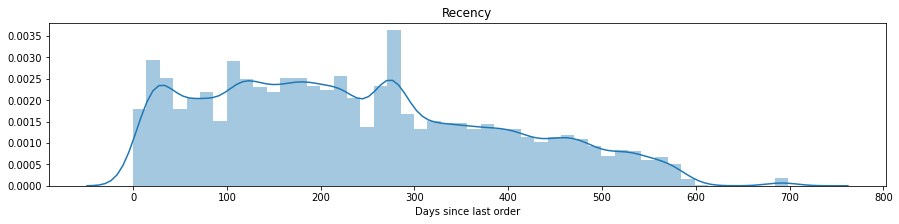

In [8]:
plt.figure(figsize=(15, 3))
sns.distplot(df_rfm['recency'])

plt.xlabel('Days since last order')
plt.title('Recency');

This chart makes sense because we see that there is the spike at round about 270 days before the reference day. That falls in the time period of the heavy Black Friday sales event where a lot of customers placed their latest order.

### Frequency

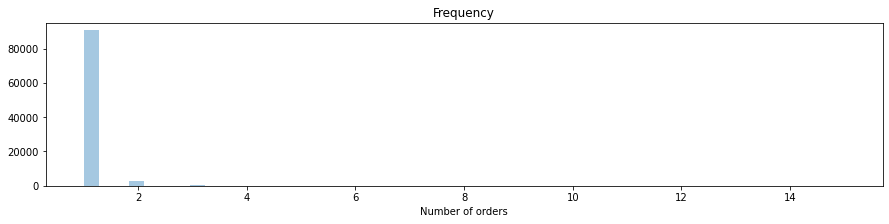

In [9]:
plt.figure(figsize=(15, 3))
sns.distplot(df_rfm['frequency'], kde=False);

plt.xlabel('Number of orders')
plt.title('Frequency');

We have seen this chart before. There are many customers which only placed one order. As hinted in the initial "Olist Business Trend Analysi", the error which many will likely get trapped is by simply applying `count of order_id` during grouping by customer_unique_id. Reason why this leads to a wrong result:
- Quantity in the original order table is created by number of rows (order quantity = 4 means 4 rows of data)
- Two SKUs (products) means two separate rows in the data table

=> If we group by user "X" whose order contains procuct "A" with quantity 2 and procuct "B" with quantity 1, we will get 3 as count for this customer while in reality only one single order was placed.

### Monetary

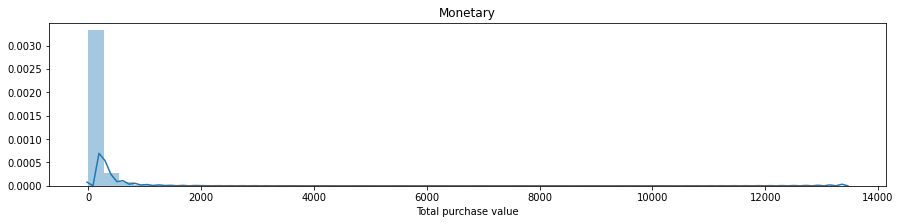

In [10]:
plt.figure(figsize=(15, 3))
sns.distplot(df_rfm['total_payment']);

plt.xlabel('Total purchase value')
plt.title('Monetary');

In [11]:
# Frequencies:
df_rfm['frequency'].unique()

array([ 1,  2,  3,  4,  6,  7,  5,  9, 15], dtype=int64)

In [12]:
def assign_frequency(x):
    '''
    Function to assign frequency score

    Input:
    - x - order placed, integer

    Output:
    - F - frequency score
    '''
    
    if x >= 7:
        return 4
    elif x >= 4:
        return 3
    elif x >= 2:
        return 2
    else:
        return 1

In [13]:
# Distribute values to quartiles (for 4 segments) and add to dataframe
df_rfm['R'] = pd.qcut(df_rfm['recency'], q=4, labels=range(4, 0, -1))
df_rfm['F'] = df_rfm['frequency'].apply(assign_frequency)
df_rfm['M'] = pd.qcut(df_segmented_customers['total_payment'], q=4, labels=range(1, 5))
df_rfm.head()

,customer_unique_id,recency,frequency,total_payment,avg_payment,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,129.90,7787,-23.353375,-46.824556,4,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,18.90,6053,-23.559455,-46.789721,4,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,69.00,88115,-27.535895,-48.630935,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,25.99,66812,-1.307324,-48.481083,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,180.00,18040,-23.508786,-47.462823,2,1,4


I now need to label the RFM combination and calculate the RFM score.

In [14]:
# Define- and assign label to dataframe
df_rfm['segment_RFM'] = df_rfm['R'].astype(str)\
    + df_rfm['F'].astype(str)\
    + df_rfm['M'].astype(str)
df_rfm['score_rfm'] = df_rfm[['R','F','M']].sum(axis=1)

In [15]:
# These are the customer RFM segments with the appropriate approach suggestion
dict_rfm_tiers = {'Best customer': 'Personalized communication, offer loyalty program, no promotional offers needed', 'Big Spender': 'Make them feel valued and offer quality products, encourage to stick with brands', 'Loyalist': 'Offer loyalty program', 'Potential Loyalists': 'Recommend products and offer discounts', 'Almost Lost': 'Try to win them with limited sales promotions', 'Hibernating': 'Make great offers with big discounts', 'Lost Customer': 'Do not spent much effort and money to win them'}

In [16]:
def rfm_assiner(df):
    '''
    Function to assign RFM classes according conditions.

    Input:
    - df - dataframe containing RFM score and RFM segment key

    Output:
    - returns a RFM segment class (str)
    '''
    if (int(df['segment_RFM']) >= 434) or (df['score_rfm'] >= 9):
        return 'Best customer'
    elif (df['score_rfm'] >= 8) and (df['M'] == 4):
        return 'Big Spender'
    elif (df['score_rfm'] >= 6) and (df['F'] >= 2):
        return 'Loyalist'
    elif (int(df['segment_RFM']) >= 231) or (df['score_rfm'] >= 6):
        return 'Potential Loyalists'
    elif ((int(df['segment_RFM']) >= 121) and (df['R'] == 1)) or df['score_rfm'] == 5:
        return 'Almost Lost'
    elif (df['score_rfm'] >= 4) and (df['R'] == 1):
        return 'Hibernating'
    else:
        return 'Lost Customer'

In [17]:
df_rfm['customer_rfm_segment'] = df_rfm.apply(rfm_assiner, axis=1)

In [18]:
df_rfm['marketing_approach']\
    = df_rfm['customer_rfm_segment'].apply(lambda x: dict_rfm_tiers[x])

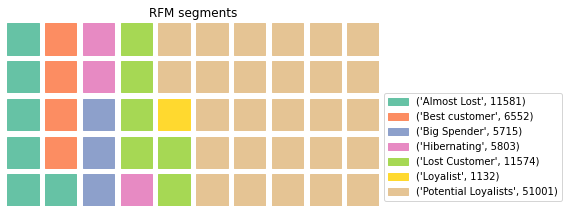

In [19]:
# Vizualize segment sizes with the waffe chart
oa.plot_waffle_chart(df_rfm, 'customer_unique_id', 'count', 'RFM segments', 'customer_rfm_segment')

In [20]:
# Make a clean table for presentation
df_tbl_rfm = df_rfm.groupby('customer_rfm_segment').agg(
    Count = ('customer_unique_id', 'count'),
    Recency = ('recency', 'mean'),
    Frequency = ('frequency', 'mean'),
    Monetary = ('total_payment', 'mean'),
    Strategy = ('marketing_approach', 'unique'),
).round(1)
df_tbl_rfm

,Count,Recency,Frequency,Monetary,Strategy
customer_rfm_segment,,,,,
Almost Lost,11581,360.9,1.0,88.8,[Try to win them with limited sales promotions]
Best customer,6552,66.6,1.2,356.4,"[Personalized communication, offer loyalty pro..."
Big Spender,5715,172.9,1.1,346.3,[Make them feel valued and offer quality produ...
Hibernating,5803,446.5,1.0,64.8,[Make great offers with big discounts]
Lost Customer,11574,367.6,1.0,29.0,[Do not spent much effort and money to win them]
Loyalist,1132,290.9,2.1,173.4,[Offer loyalty program]
Potential Loyalists,51001,184.2,1.0,136.7,[Recommend products and offer discounts]


## Conclusion

- The order frequency and order amounts are concentrated on the lower end. This is what we have repeatedly have seen before.
- The biggest RFM segment is the group of `Potential Loyalists`. These are customers that need to be targeted with offers and discounts in order to make the business successful.
- There is a good base of `Best Customers`, which is good news for the business.
- Some effort needs to be spent to target `hibernating` customers and customers which are `almost lost`

---
## <a class="k_means" id="rfm">VI. K Means Clustering</a>

K-Means Clustering is a method that supports identifying clusters in unlabeled data. I will use the existing dataset and apply sklearns K-means algorithm to find underlying segments that are different from the aribrarily chosen RFM classes.

Step one is to normalize the data to have all features on the same scale. This is to avoid that one feature dominates others.

In [21]:
df_rfm_trans = df_rfm[['recency', 'frequency', 'total_payment']] # dataframe we want to use for clustering
scaler = StandardScaler() # set up scaler
scaler.fit(df_rfm_trans) # fit our data to the scaler
df_rfm_norm = scaler.transform(df_rfm_trans) # trasnform data with scaler
df_rfm_norm = pd.DataFrame(data=df_rfm_norm, index=df_rfm_trans.index, columns=df_rfm_trans.columns) # convert back to dataframe

In [22]:
# Check
df_rfm_norm.head()

,recency,frequency,total_payment
0,-0.828857,-0.159829,-0.054343
1,-0.809198,-0.159829,-0.568964
2,1.962860,-0.159829,-0.336689
3,0.547341,-0.159829,-0.536093
4,0.331081,-0.159829,0.177931


Next step: K-means

In [23]:
# Let's start with 2 clusters
k_means = KMeans(n_clusters=2, random_state=1)
k_means.fit(df_rfm_norm)

KMeans(n_clusters=2, random_state=1)

In [24]:
# Cretate dataframe to display table
cluster = k_means.labels_
df_rfm_2 = df_rfm.assign(Cluster=cluster)
df_group_2 = df_rfm_2.groupby('Cluster')
df_group_2.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_payment': ['mean', 'count']
  }).round(1)

recency frequency total_payment       
           mean      mean          mean  count
Cluster                                       
0         238.0       1.0         137.5  90551
1         220.0       2.1         276.1   2807

In [25]:
# Calculate standard error
k_means.inertia_

201977.95721188947

The number of clusters impact the standard error. Higher number of clusters will lower the error, but  Let's automate the process.

By plotting the error against the number of clusters we can determin the condition at which the gain of information becomes marginal ("Ellbow" method).

In [26]:
def k_means_func(dat, n_clusters):
    '''
    Function to calculate the standard error for a given number of clusters.

    Inputs:
    - dat - dataframe with normalized data
    - n_clusters - number of clusters

    Output:
    - sse - standard error
    '''
    k_means = KMeans(n_clusters=n_clusters, random_state=1)
    k_means.fit(df_rfm_norm)
    
    return k_means.inertia_

In [27]:
# Generating dictionary with errors
dict_k_sse = {}
for i in range(1, 10):
    dict_k_sse[i] = k_means_func(df_rfm_norm, i)

In [28]:
dict_k_sse

{1: 280073.9999999976,
 2: 201977.95721188947,
 3: 138056.8970486162,
 4: 92050.90808443575,
 5: 77351.16827945324,
 6: 63303.315145540175,
 7: 53880.91914825221,
 8: 48241.356119448305,
 9: 43393.589144248486}

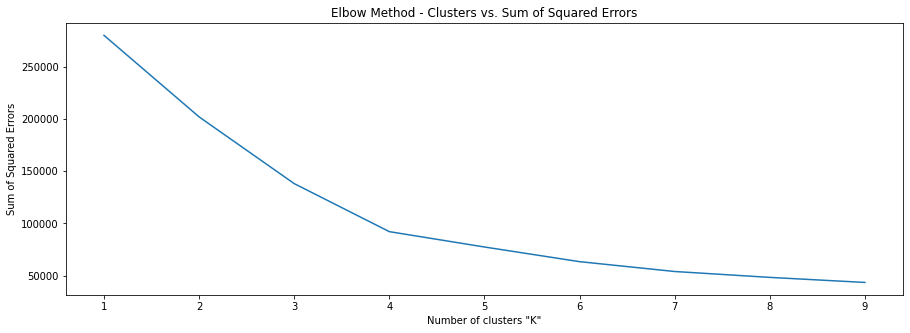

In [29]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=list(dict_k_sse.keys()), y=list(dict_k_sse.values()))

plt.xlabel('Number of clusters "K"')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method - Clusters vs. Sum of Squared Errors');

The `Ellbow Method` revealed that a cluster number of 4 is a suitable value.

In [30]:
# Let's see how this clustering looks like
k_means = KMeans(n_clusters=4, random_state=1)
k_means.fit(df_rfm_norm)
cluster = k_means.labels_
df_rfm_4 = df_rfm.assign(Cluster=cluster)
df_group_4 = df_rfm_4.groupby('Cluster')
df_group_4.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_payment': ['mean', 'count']
  }).round(1)

recency frequency total_payment       
           mean      mean          mean  count
Cluster                                       
0         387.2       1.0         114.1  37566
1         219.9       2.1         243.2   2774
2         127.8       1.0         113.4  50832
3         237.1       1.0        1142.7   2186

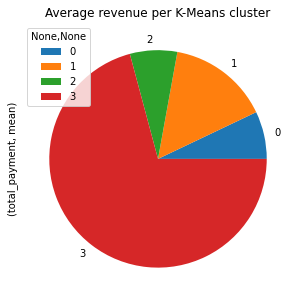

In [31]:
# Plot mean purchase value per K-Means cluster
plt.figure(figsize=(10, 5))
df_group_4.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_payment': ['mean', 'count']
  }).round(1)['total_payment', 'mean'].plot(kind='pie', legend=True)
  
plt.title('Average revenue per K-Means cluster');

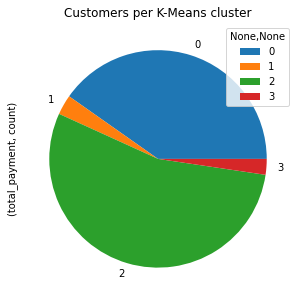

In [32]:
# Plot customers per K-Means cluster
plt.figure(figsize=(10, 5))
df_group_4.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_payment': ['mean', 'count']
  }).round(1)['total_payment', 'count'].plot(kind='pie', legend=True)

plt.title('Customers per K-Means cluster');

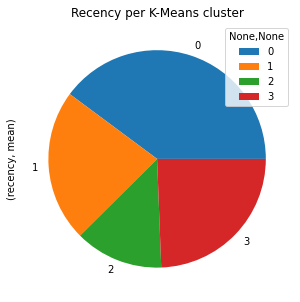

In [33]:
# Plot recency per K-Means cluster
plt.figure(figsize=(10, 5))
df_group_4.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'total_payment': ['mean', 'count']
  }).round(1)['recency', 'mean'].plot(kind='pie', legend=True)

plt.title('Recency per K-Means cluster');

In [34]:
#x = df_rfm_4['recency']
#y = df_rfm_4['frequency']
#z = df_rfm_4['total_payment']

#fig = go.Figure(data=[go.Scatter3d(
#    x=x,
#    y=y,
#    z=z,
#    mode='markers',
#    marker=dict(
#        size=2,
#        color=df_rfm_4['Cluster'],               
#        #colorscale='thermal',
#        opacity=0.8
#    )
#)])

#fig.update_layout(scene = dict(
#    xaxis_title='Recency',
#    yaxis_title='Frequency',
#    zaxis_title='Monetary'),
#    width=700,
#    margin=dict(r=20, b=10, l=10, t=10))

#fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
#fig.show()

The above scatter plot visuzlizes how K-Means clusters the data into four segments.
- Group 0: Early Customers with low purchase value
- Group 1: Loyal Customers
- Group 2: Hibernating Customers with low purchase value
- Group 3: Big Spenders

It would now be interesting if these clusters have some geological correlation.

In [35]:
dict_color = {
    0: 'blue',
    1: 'orange',
    2: 'green',
    3: 'red'
    }

In [36]:
df_rfm_4['color'] = df_rfm_4['Cluster'].map(dict_color)

In [37]:
df_rfm_4.head()

,customer_unique_id,recency,frequency,total_payment,avg_payment,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,R,F,M,segment_RFM,score_rfm,customer_rfm_segment,marketing_approach,Cluster,color
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90,129.90,7787,-23.353375,-46.824556,4,1,3,413,8.0,Potential Loyalists,Recommend products and offer discounts,2,green
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,18.90,6053,-23.559455,-46.789721,4,1,1,411,6.0,Potential Loyalists,Recommend products and offer discounts,2,green
2,0000f46a3911fa3c0805444483337064,537,1,69.00,69.00,88115,-27.535895,-48.630935,1,1,2,112,4.0,Hibernating,Make great offers with big discounts,0,blue
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,25.99,66812,-1.307324,-48.481083,2,1,1,211,4.0,Lost Customer,Do not spent much effort and money to win them,0,blue
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,180.00,18040,-23.508786,-47.462823,2,1,4,214,7.0,Potential Loyalists,Recommend products and offer discounts,0,blue


In [44]:
sample_k_means_4 = df_rfm_4.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'geolocation_lat': 'first',
        'geolocation_lng': 'first',
        'color': lambda x:x.value_counts().index[0]
        }).sample(n=200)

In [45]:
oa.plot_map(sample_k_means_4, 'K-Means Cluster Customers', 0, 3, 'Cluster', 2, True)

## Conclusion

- K-Means clustering reveals that four customer segments generates an effective fit for the data
- There are two important segments for the business: `New Low-Spenders`, `Big Spenders`